In [1]:
import pandas as pd
import numpy as np
import os as os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import acessos as ac
import funcionalidade as fc
import re
from pylift import TransformedOutcome
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Obtenção de dados - fonte da tabela na pasta sql

In [4]:
query = """
  
select * from customer_sandbox_zone.dados_estudo_mgm_flavia

"""

df = ac.df_athena('flavia-costa', query)

In [5]:
len(df)

1035884

In [6]:
df.dtypes

cpf                          object
tempo_aprovacao             float64
tempo_relacionamento        float64
ganho_limite                float64
ds_risk_type                 object
gender                       object
nr_declared_income          float64
ds_region                    object
flag_autonomo                 int64
max_limite                  float64
max_qtd_if                    int64
avg_utilizado_interno       float64
sum_utilizado_interno       float64
avg_utilizado_mercado       float64
sum_utilizado_mercado       float64
nr_chaves_importantes       float64
nr_antecipacao_fatura       float64
nr_bolso_ativo              float64
nr_trans_mov_conta          float64
nr_purchases_virtual        float64
avg_vl_total_spending       float64
nr_purchases_online         float64
nr_acessos                  float64
pc_acessos_lojawill         float64
flag_mgm                    float64
dias_atraso                   int64
ordem                         int64
flag_limite_insuficiente    

In [7]:
df.head()

,cpf,tempo_aprovacao,tempo_relacionamento,ganho_limite,ds_risk_type,gender,nr_declared_income,ds_region,flag_autonomo,max_limite,...,nr_purchases_virtual,avg_vl_total_spending,nr_purchases_online,nr_acessos,pc_acessos_lojawill,flag_mgm,dias_atraso,ordem,flag_limite_insuficiente,share_of_wallet
0,08826281432,3.0,350.0,340.0,3. Medio Risco,MALE,1733.0,Nordeste,0,1200.0,...,0.0,1976.163333,4.0,388.0,0.005155,1.0,0,29672,1,0.457809
1,27527276827,4.0,351.0,500.0,4. Baixo Risco,FEMALE,2200.0,Nordeste,0,2700.0,...,0.0,926.520000,1.0,135.0,0.000000,1.0,0,29673,1,0.258186
2,12899652770,1.0,336.0,140.0,2. Alto Risco,FEMALE,800.0,Sudeste,1,500.0,...,0.0,617.965455,10.0,450.0,0.013333,1.0,0,29674,1,0.435081
3,42358143898,2.0,334.0,1840.0,3. Medio Risco,FEMALE,3500.0,Sudeste,0,2200.0,...,9.0,2316.790000,24.0,363.0,0.000000,1.0,0,29675,1,0.332347
4,15264522600,2.0,301.0,400.0,4. Baixo Risco,MALE,4000.0,Sudeste,1,1500.0,...,4.0,726.062222,35.0,150.0,0.006667,1.0,0,29676,1,0.192833


In [8]:
df.isnull().sum()

cpf                              0
tempo_aprovacao               3171
tempo_relacionamento          3171
ganho_limite                120421
ds_risk_type                     0
gender                        9190
nr_declared_income               0
ds_region                       12
flag_autonomo                    0
max_limite                       0
max_qtd_if                       0
avg_utilizado_interno        97612
sum_utilizado_interno        97612
avg_utilizado_mercado        97612
sum_utilizado_mercado        97612
nr_chaves_importantes       375425
nr_antecipacao_fatura       375425
nr_bolso_ativo              375425
nr_trans_mov_conta          375425
nr_purchases_virtual        122126
avg_vl_total_spending       122126
nr_purchases_online         122126
nr_acessos                  500000
pc_acessos_lojawill         500000
flag_mgm                    500000
dias_atraso                      0
ordem                            0
flag_limite_insuficiente         0
share_of_wallet     

### Definindo tipos de var e lidando com missings

In [9]:
id_columns = ['cpf', 'ordem']
cat_columns = df.drop(id_columns, axis = 1).select_dtypes('object').columns
num_columns = df.drop(id_columns, axis = 1).select_dtypes(exclude=['object']).columns

In [10]:
df.drop(id_columns, axis=1).describe()

,tempo_aprovacao,tempo_relacionamento,ganho_limite,nr_declared_income,flag_autonomo,max_limite,max_qtd_if,avg_utilizado_interno,sum_utilizado_interno,avg_utilizado_mercado,...,nr_trans_mov_conta,nr_purchases_virtual,avg_vl_total_spending,nr_purchases_online,nr_acessos,pc_acessos_lojawill,flag_mgm,dias_atraso,flag_limite_insuficiente,share_of_wallet
count,1.032713e+06,1.032713e+06,915463.000000,1.035884e+06,1.035884e+06,1.035884e+06,1.035884e+06,938272.000000,9.382720e+05,9.382720e+05,...,660459.000000,913758.000000,913758.000000,913758.000000,535884.000000,535884.000000,535884.000000,1.035884e+06,1.035884e+06,927450.000000
mean,1.467497e+01,7.992940e+02,1361.795970,5.204998e+06,2.623421e-01,3.047943e+03,4.566073e+00,2085.512372,2.946778e+04,9.958559e+03,...,56.714933,4.228206,1084.588711,50.908050,144.418230,0.014224,0.066962,6.994606e-02,6.988012e-01,0.330262
std,5.375132e+01,6.322262e+02,2768.519827,2.768569e+09,4.399079e-01,3.546639e+03,3.471403e+00,3425.255387,6.928761e+04,5.712937e+04,...,207.358497,27.571874,1507.814411,127.839466,252.010962,0.045851,0.249957,3.215492e-01,4.587791e-01,0.258446
min,-3.000000e+01,1.000000e+00,-9900.000000,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,-68.136667,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,1.000000e+00,2.170000e+02,0.000000,1.000000e-02,0.000000e+00,9.000000e+02,2.000000e+00,403.917500,2.260800e+03,9.976875e+02,...,6.000000,0.000000,407.580000,2.000000,26.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.102252
50%,2.000000e+00,6.640000e+02,210.000000,1.500000e+03,0.000000e+00,1.770000e+03,4.000000e+00,1136.845000,1.158592e+04,2.706268e+03,...,16.000000,0.000000,702.095606,12.000000,81.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,0.302927
75%,6.000000e+00,1.345000e+03,1300.000000,3.000000e+03,1.000000e+00,3.500000e+03,6.000000e+00,2470.245000,3.133936e+04,7.248609e+03,...,45.000000,0.000000,1238.191250,47.000000,174.000000,0.009804,0.000000,0.000000e+00,1.000000e+00,0.514021
max,1.156000e+03,2.309000e+03,98300.000000,2.220000e+12,1.000000e+00,9.900000e+04,4.100000e+01,221054.240000,6.364549e+06,2.470661e+07,...,57385.000000,5150.000000,117023.200000,12032.000000,16752.000000,1.000000,1.000000,2.000000e+00,1.000000e+00,1.000000


In [11]:
for column in df.columns:
  if df[column].dtype == 'object':
    df[column].fillna(df[column].mode()[0], inplace = True)
  elif df[column].dtype == 'string':
    df[column].fillna(df[column].mode()[0], inplace = True)
  elif df[column].dtype != 'object':
    df[column].fillna(df[column].median(), inplace = True)

In [12]:
df.isnull().sum()

cpf                         0
tempo_aprovacao             0
tempo_relacionamento        0
ganho_limite                0
ds_risk_type                0
gender                      0
nr_declared_income          0
ds_region                   0
flag_autonomo               0
max_limite                  0
max_qtd_if                  0
avg_utilizado_interno       0
sum_utilizado_interno       0
avg_utilizado_mercado       0
sum_utilizado_mercado       0
nr_chaves_importantes       0
nr_antecipacao_fatura       0
nr_bolso_ativo              0
nr_trans_mov_conta          0
nr_purchases_virtual        0
avg_vl_total_spending       0
nr_purchases_online         0
nr_acessos                  0
pc_acessos_lojawill         0
flag_mgm                    0
dias_atraso                 0
ordem                       0
flag_limite_insuficiente    0
share_of_wallet             0
dtype: int64

In [13]:
df['flag_mgm'].value_counts()

0.0    1000000
1.0      35884
Name: flag_mgm, dtype: int64

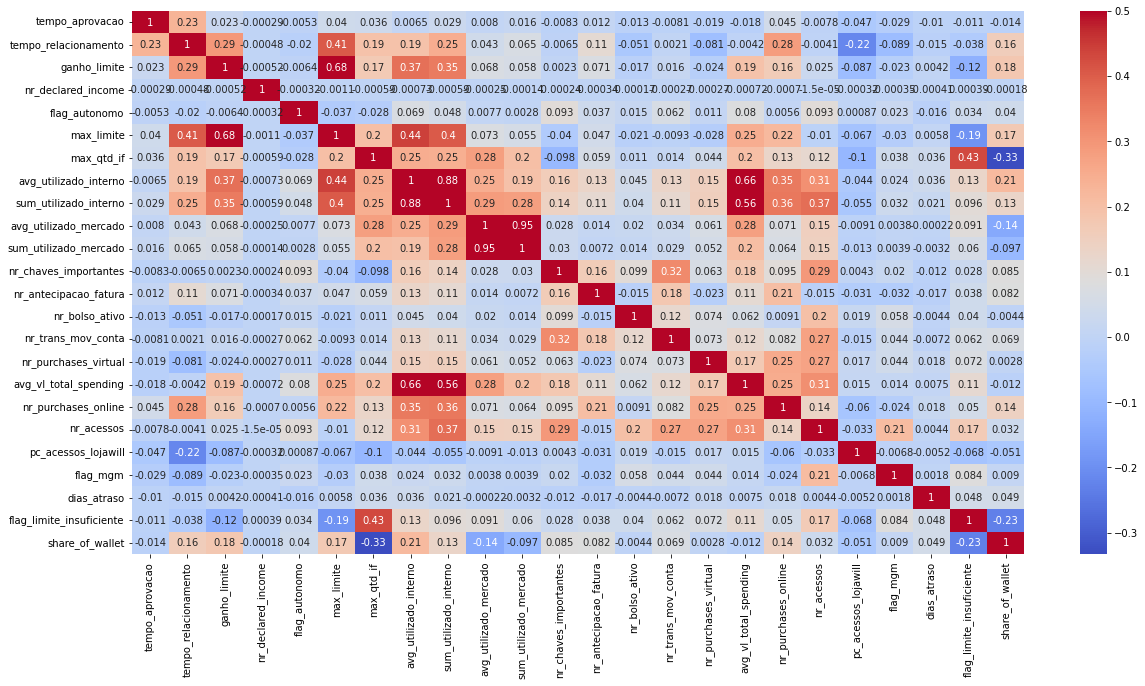

In [14]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(df.drop(id_columns, axis=1).corr(), annot=True, cmap="coolwarm", vmax=0.5)
plt.show()

In [15]:
cat_columns

Index(['ds_risk_type', 'gender', 'ds_region'], dtype='object')

In [16]:
df.isnull().sum()

cpf                         0
tempo_aprovacao             0
tempo_relacionamento        0
ganho_limite                0
ds_risk_type                0
gender                      0
nr_declared_income          0
ds_region                   0
flag_autonomo               0
max_limite                  0
max_qtd_if                  0
avg_utilizado_interno       0
sum_utilizado_interno       0
avg_utilizado_mercado       0
sum_utilizado_mercado       0
nr_chaves_importantes       0
nr_antecipacao_fatura       0
nr_bolso_ativo              0
nr_trans_mov_conta          0
nr_purchases_virtual        0
avg_vl_total_spending       0
nr_purchases_online         0
nr_acessos                  0
pc_acessos_lojawill         0
flag_mgm                    0
dias_atraso                 0
ordem                       0
flag_limite_insuficiente    0
share_of_wallet             0
dtype: int64

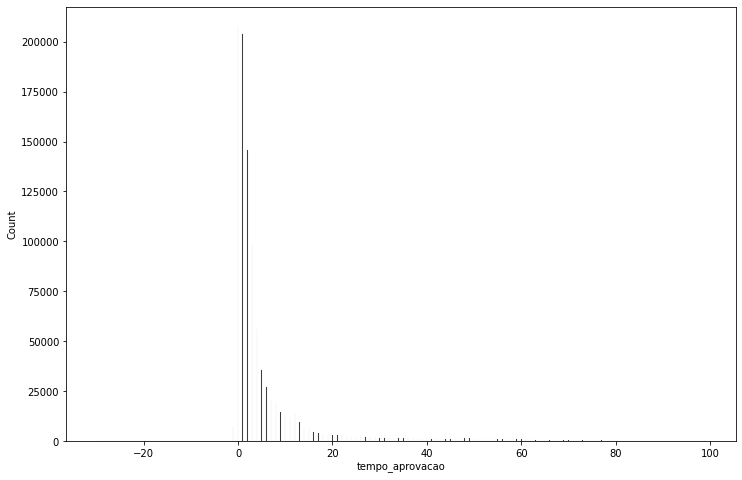

In [18]:
plt.figure(figsize=(12,8))
sns.histplot(data = df.query('tempo_aprovacao < 100'), x = 'tempo_aprovacao', color = 'black')
plt.show()

In [19]:
df['flag_autonomo'].value_counts()


0    764128
1    271756
Name: flag_autonomo, dtype: int64

In [20]:
df['nr_bolso_ativo'].value_counts()

0.0     1018895
1.0       11504
2.0        3200
3.0         980
4.0         631
5.0         201
6.0         160
8.0         132
7.0          60
12.0         38
10.0         24
9.0          22
16.0         16
24.0          4
14.0          4
11.0          4
20.0          3
18.0          2
15.0          2
30.0          1
13.0          1
Name: nr_bolso_ativo, dtype: int64

In [21]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing as pr
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.decomposition import PCA
from sklearn import tree

In [22]:
df.columns

Index(['cpf', 'tempo_aprovacao', 'tempo_relacionamento', 'ganho_limite',
       'ds_risk_type', 'gender', 'nr_declared_income', 'ds_region',
       'flag_autonomo', 'max_limite', 'max_qtd_if', 'avg_utilizado_interno',
       'sum_utilizado_interno', 'avg_utilizado_mercado',
       'sum_utilizado_mercado', 'nr_chaves_importantes',
       'nr_antecipacao_fatura', 'nr_bolso_ativo', 'nr_trans_mov_conta',
       'nr_purchases_virtual', 'avg_vl_total_spending', 'nr_purchases_online',
       'nr_acessos', 'pc_acessos_lojawill', 'flag_mgm', 'dias_atraso', 'ordem',
       'flag_limite_insuficiente', 'share_of_wallet'],
      dtype='object')

In [23]:
#tempo_relacionamento, nr_acessos, share of wallet, declared income,  purchases on line, max_limite, Avg Spending, trans mov conta, limite insuficiente, ganho limite, percentual loja will
preditores = ['tempo_aprovacao', 'flag_autonomo', 'dias_atraso', 'tempo_relacionamento', 'avg_vl_total_spending', 'nr_declared_income', 'ganho_limite', 'flag_limite_insuficiente', 'share_of_wallet', 'nr_trans_mov_conta', 'nr_purchases_online']
target = ['flag_mgm']

In [21]:
#df_model = pd.get_dummies(df, columns=cat_columns)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df[preditores]
                                                    , df[target]
                                                    , random_state=42, test_size=0.20)

In [25]:
x_train = x_train.replace([np.inf, -np.inf], 0)
x_test = x_test.replace([np.inf, -np.inf], 0)

In [26]:
pcaComp = PCA(n_components = 0.99)
pcaModel = pcaComp.fit(x_train)
x_train_reduced = pcaModel.transform(x_train)

In [27]:
x_train.shape[1]

11

In [28]:
x_train_reduced.shape[1]

1

In [29]:
pcaComp = PCA(n_components = 2)
pcaModel = pcaComp.fit(x_train)
x_train_reduced = pcaModel.transform(x_train)

In [30]:
x_train_reduced.shape[1]

2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


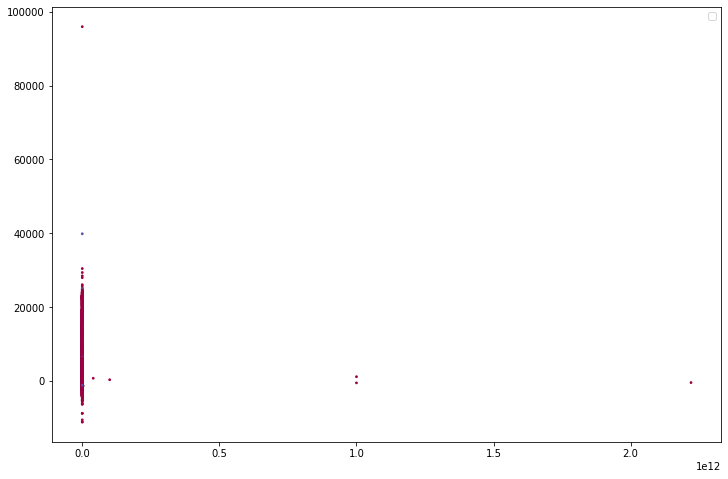

In [31]:
plt.figure(figsize=(12,8))
plt.scatter(x_train_reduced[:, 0], x_train_reduced[:, 1], s=3, c=y_train['flag_mgm'], cmap='Spectral')
plt.show()

In [32]:
scaler = pr.RobustScaler().fit(x_train) #para outliers

#aplicando scaler definido
x_train_nr = scaler.fit_transform(x_train)
x_test_nr = scaler.fit_transform(x_test)

In [49]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42) #early_stopping_rounds=2
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [50]:
#validação inicial por cross validation
scores = cross_val_score(xgb_model, x_train, y_train, scoring='f1_macro' , cv = StratifiedKFold(n_splits=5))
print("%0.2f F1 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.50 F1 with a standard deviation of 0.00


<Figure size 1440x1440 with 0 Axes>

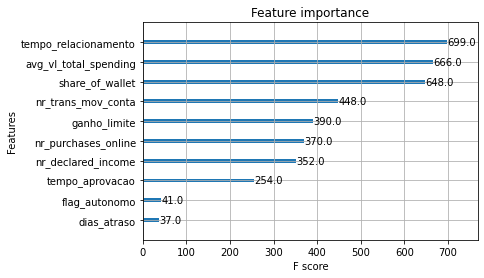

In [53]:
plt.figure(figsize=(20,20))
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()

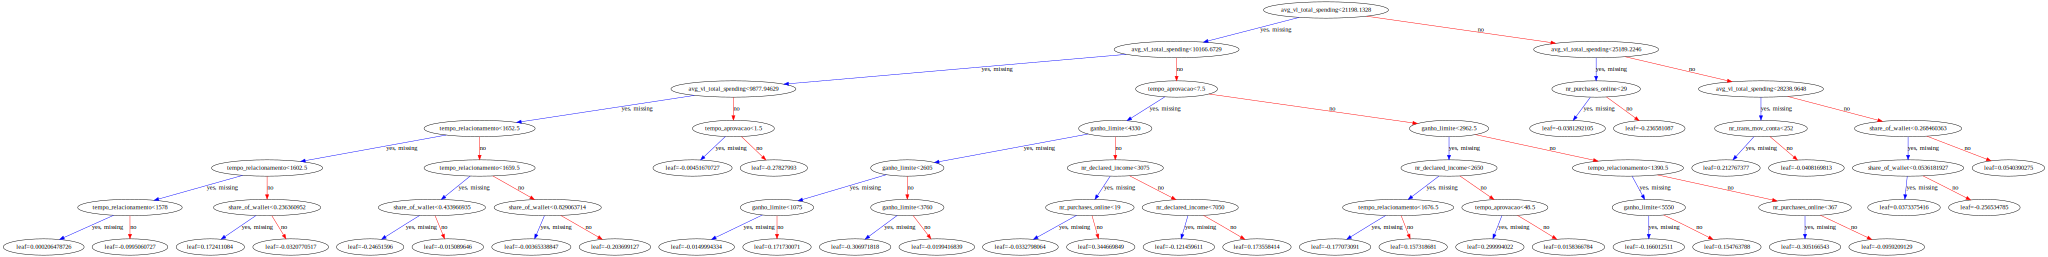

In [54]:
import graphviz

xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration)

In [55]:
y_predicted = xgb_model.predict(x_test)

In [56]:
clf_results = pd.DataFrame()
clf_results['predito'] = y_predicted
clf_results['real'] = y_test.values

df_confusion = pd.crosstab(clf_results.real, clf_results.predito)
df_confusion.head()

predito,0,1
real,,
0.0,199886,50
1.0,7204,37


In [57]:
cont = len(y_test)
#falso negativo e positivo
fp = df_confusion.iloc[0,1]
fn = df_confusion.iloc[1,0]
#verdadeiro (true) positivo e negativo
tp = df_confusion.iloc[1,1]
tn = df_confusion.iloc[0,0]
#recall - taxa de captura de positivos
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)
print(f" F1: {f1}")
print(f" Recall: {recall}")
print(f" Precision: {precision}")

auroc = metrics.roc_auc_score(y_test, y_predicted).round(5)
accuracy = metrics.accuracy_score(y_test, y_predicted).round(5)
print("AUROC: " + str(auroc) + " e ACCURACY: " + str(accuracy))

 F1: 0.01009825327510917
 Recall: 0.005109791465267228
 Precision: 0.42528735632183906
AUROC: 0.50243 e ACCURACY: 0.96499


In [58]:
#Matriz 
y_predicted_clf_proba = xgb_model.predict_proba(x_test)[:, 1]
clf_results['Probabilidade'] = y_predicted_clf_proba
clf_results['fx_score'] = np.round(clf_results['Probabilidade'], 1)
clf_results['cpf'] =  1

clf_results_agg = clf_results.groupby('fx_score').agg({'real': ['count', 'sum']})
clf_results_agg.columns = clf_results_agg.columns.droplevel(0)
clf_results_agg['taxa_evento'] = clf_results_agg['sum'] / clf_results_agg['count']


In [59]:
clf_results_agg

,count,sum,taxa_evento
fx_score,,,
0.0,169290,652.0,0.003851
0.1,16440,1861.0,0.113200
0.2,16041,3114.0,0.194128
0.3,4339,1234.0,0.284397
0.4,843,290.0,0.344009
0.5,183,74.0,0.404372
0.6,36,13.0,0.361111
0.7,5,3.0,0.600000


In [61]:
#!pip install te2rules

ERROR: launchpadlib 1.10.13 requires testresources, which is not installed.
ERROR: texthero 1.1.0 has requirement spacy<3.0.0, but you'll have spacy 3.6.0 which is incompatible.


In [62]:
import te2rules
from te2rules.explainer import ModelExplainer
#só funciona com Gradient Booster ou RF

In [64]:
""" model_explainer = ModelExplainer(
    model=xgb_model, 
    feature_names=preditores
)

rules = model_explainer.explain(
    X=x_train, y=y_predicted,
    num_stages = 10,
    min_precision = 0.95
) """

' model_explainer = ModelExplainer(\n    model=xgb_model, \n    feature_names=preditores\n)\n\nrules = model_explainer.explain(\n    X=x_train, y=y_predicted,\n    num_stages = 10,\n    min_precision = 0.95\n) '

In [39]:
#tsne_plot(x_train_nr, y_train[target])

In [65]:
#balanceamento - caso necessário
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 42)
x_train, y_train = ros.fit_resample(x_train, y_train)

In [66]:
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [67]:
scores = cross_val_score(xgb_model, x_train, y_train, scoring='f1_macro' , cv = StratifiedKFold(n_splits=5))
print("%0.2f F1 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.89 F1 with a standard deviation of 0.00


<Figure size 1440x1440 with 0 Axes>

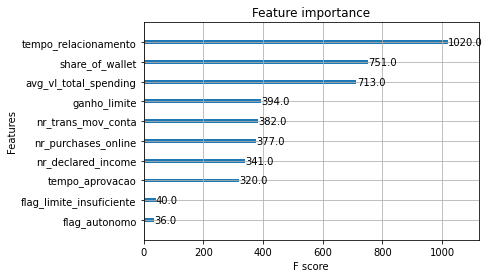

In [68]:
plt.figure(figsize=(20,20))
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()

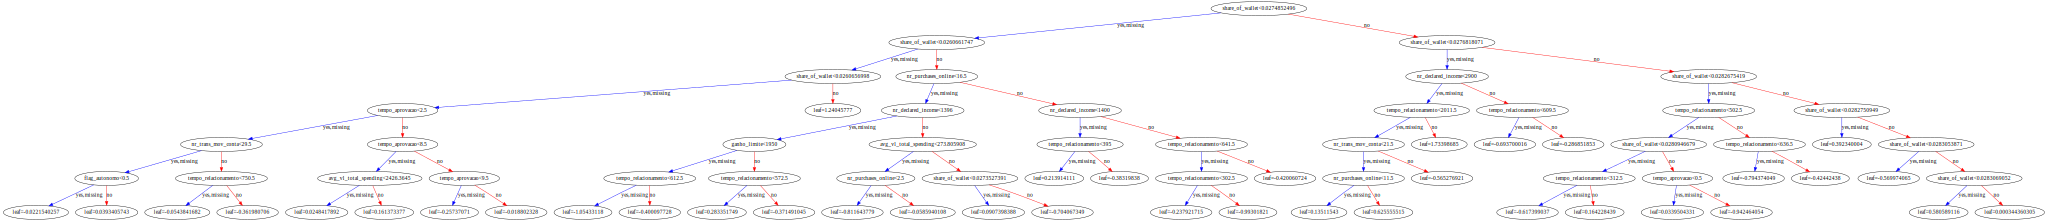

In [69]:
xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration)

In [70]:
y_predicted = xgb_model.predict(x_test)

In [71]:
clf_results = pd.DataFrame()
clf_results['predito'] = y_predicted
clf_results['real'] = y_test.values

df_confusion = pd.crosstab(clf_results.real, clf_results.predito)
df_confusion.head()

predito,0,1
real,,
0.0,167423,32513
1.0,610,6631


In [72]:
cont = len(y_test)
#falso negativo e positivo
fp = df_confusion.iloc[0,1]
fn = df_confusion.iloc[1,0]
#verdadeiro (true) positivo e negativo
tp = df_confusion.iloc[1,1]
tn = df_confusion.iloc[0,0]
#recall - taxa de captura de positivos
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)
print(f" F1: {f1}")
print(f" Recall: {recall}")
print(f" Precision: {precision}")

auroc = metrics.roc_auc_score(y_test, y_predicted).round(5)
accuracy = metrics.accuracy_score(y_test, y_predicted).round(5)
print("AUROC: " + str(auroc) + " e ACCURACY: " + str(accuracy))

 F1: 0.28591139376953756
 Recall: 0.9157574920591078
 Precision: 0.16940016349887593
AUROC: 0.87657 e ACCURACY: 0.84012


In [73]:
#Matriz 
y_predicted_clf_proba = xgb_model.predict_proba(x_test)[:, 1]
clf_results['Probabilidade'] = y_predicted_clf_proba
clf_results['fx_score'] = np.round(clf_results['Probabilidade'], 1)
clf_results['cpf'] =  1

clf_results_agg = clf_results.groupby('fx_score').agg({'real': ['count', 'sum']})
clf_results_agg.columns = clf_results_agg.columns.droplevel(0)
clf_results_agg['taxa_evento'] = clf_results_agg['sum'] / clf_results_agg['count']

In [74]:
clf_results_agg

,count,sum,taxa_evento
fx_score,,,
0.0,124019,65.0,0.000524
0.1,24542,109.0,0.004441
0.2,9788,137.0,0.013997
0.3,5067,121.0,0.023880
0.4,3244,118.0,0.036375
0.5,2799,149.0,0.053233
0.6,2774,200.0,0.072098
0.7,4460,457.0,0.102466
0.8,13328,1842.0,0.138205


Três formas de obter as regras:

- Buscar os nodes da arvore
- Max e Min ou Distribuição das variaveis principais por faixa de propensão
- Função de combinação